In [35]:
# Import torch
import torch

# Automatically use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [36]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

In [37]:
# 1. Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [38]:
# 2. Define transforms (same as training)
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [39]:
# 3. Load dataset
data_dir = "../data/animals10"  # <- adjust if needed
full_data = datasets.ImageFolder(root=data_dir, transform=transform)

# 4. Split dataset into train and test
train_size = int(0.8 * len(full_data))
val_size = len(full_data) - train_size
val_data = torch.utils.data.random_split(full_data, [train_size, val_size])

# 5. Create DataLoader for test set
test_loader = DataLoader(val_data[1], batch_size=32, shuffle=False)




In [40]:
# 6 Define the model architecture (as trained)
import torch.nn.functional as F  # Import torch.nn.functional as F

class AnimalCNN(nn.Module):
    def __init__(self):
        super(AnimalCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):  # Fix indentation for the forward method
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)  
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x    

In [41]:

# 6. Load the trained model

model = AnimalCNN().to(device)

model.load_state_dict(torch.load('../models/best_model.pth', map_location=device))

model.eval()


AnimalCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [42]:

#7. Run predictions on the validation set
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [43]:

#8. classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=full_data.classes))

Classification Report:
              precision    recall  f1-score   support

        cane       0.77      0.76      0.76       992
     cavallo       0.80      0.80      0.80       546
    elefante       0.86      0.71      0.78       294
    farfalla       0.76      0.90      0.82       423
     gallina       0.89      0.83      0.86       584
       gatto       0.66      0.66      0.66       330
       mucca       0.70      0.75      0.72       365
      pecora       0.80      0.63      0.71       382
       ragno       0.88      0.84      0.86       957
  scoiattolo       0.61      0.80      0.69       363

    accuracy                           0.78      5236
   macro avg       0.77      0.77      0.77      5236
weighted avg       0.79      0.78      0.78      5236



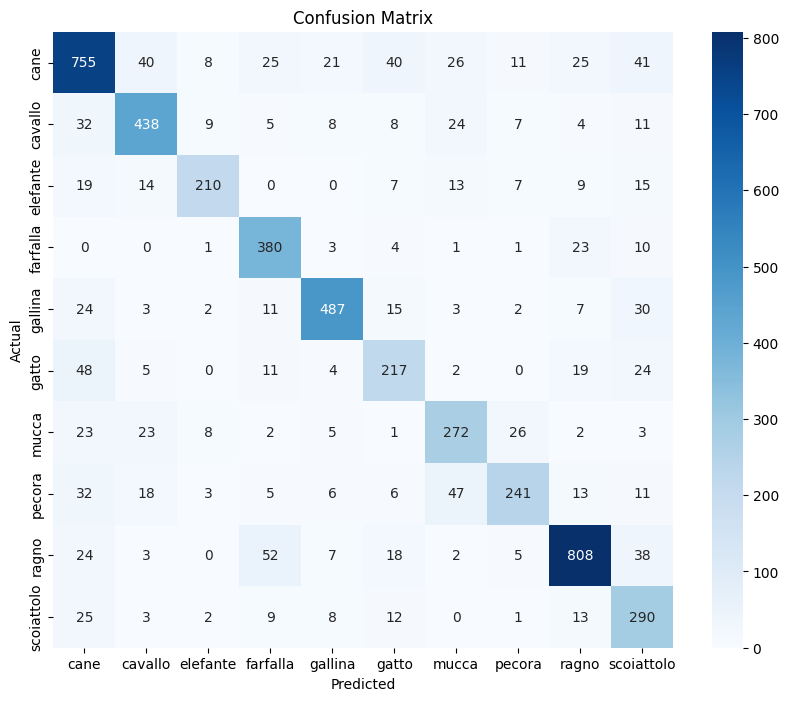

In [44]:
#9. Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=full_data.classes, yticklabels=full_data.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# 🚀 How to Improve It

# https://chatgpt.com/c/67ffab78-55a0-800b-9bcd-1fbc156cb65f